# Notebook to calculate an average histogram template for the training data used by nnUNet

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import SimpleITK as sitk
import glob
import pandas as pd
import sys
sys.path.append('../..')
from src.skmtea_utils import *

In [2]:
# path to preprocessed data
data_path = '../../../nnUNet_data/nnUNet_preprocessed/Dataset361_Menisci/nnUNetPlans_3d_fullres'

# Get all the files in the data path
files = glob.glob(data_path + '/*')

In [3]:
files.sort()
print('Number of files:', len(files))
files[:5]

Number of files: 592


['../../../nnUNet_data/nnUNet_preprocessed/Dataset361_Menisci/nnUNetPlans_3d_fullres/IWOAI_001.npy',
 '../../../nnUNet_data/nnUNet_preprocessed/Dataset361_Menisci/nnUNetPlans_3d_fullres/IWOAI_001.npz',
 '../../../nnUNet_data/nnUNet_preprocessed/Dataset361_Menisci/nnUNetPlans_3d_fullres/IWOAI_001.pkl',
 '../../../nnUNet_data/nnUNet_preprocessed/Dataset361_Menisci/nnUNetPlans_3d_fullres/IWOAI_001_seg.npy',
 '../../../nnUNet_data/nnUNet_preprocessed/Dataset361_Menisci/nnUNetPlans_3d_fullres/IWOAI_002.npy']

In [4]:
# only need the images (not masks) - files ending with .npy but not with _seg.npy
images = [f for f in files if f.endswith('.npy') and not f.endswith('_seg.npy')]
print('Number of images:', len(images))
images[:5]

Number of images: 148


['../../../nnUNet_data/nnUNet_preprocessed/Dataset361_Menisci/nnUNetPlans_3d_fullres/IWOAI_001.npy',
 '../../../nnUNet_data/nnUNet_preprocessed/Dataset361_Menisci/nnUNetPlans_3d_fullres/IWOAI_002.npy',
 '../../../nnUNet_data/nnUNet_preprocessed/Dataset361_Menisci/nnUNetPlans_3d_fullres/IWOAI_003.npy',
 '../../../nnUNet_data/nnUNet_preprocessed/Dataset361_Menisci/nnUNetPlans_3d_fullres/IWOAI_004.npy',
 '../../../nnUNet_data/nnUNet_preprocessed/Dataset361_Menisci/nnUNetPlans_3d_fullres/IWOAI_005.npy']

Image shape: (1, 160, 200, 256)


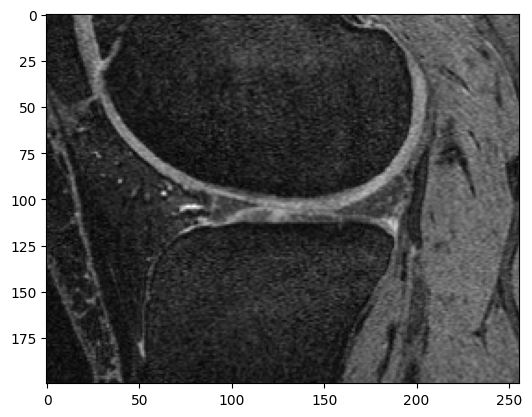

In [5]:
# show slice of first image to check
img = np.load(images[0])
print('Image shape:', img.shape)
plt.imshow(img[0,100,...], cmap='gray')

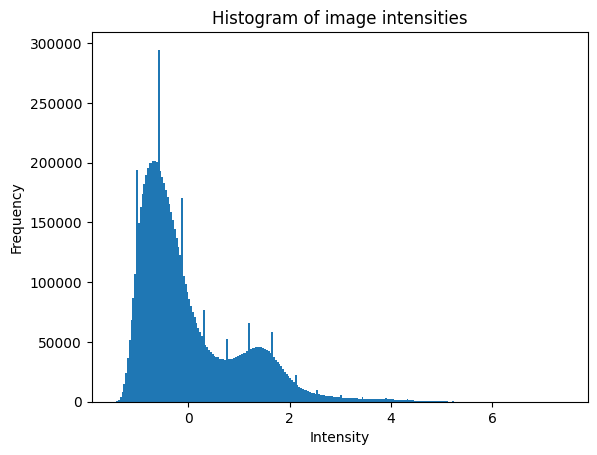

In [6]:
# plot histogram of first image
plt.hist(img.flatten(), bins=250)
plt.ylabel('Frequency')
plt.xlabel('Intensity')
plt.title('Histogram of image intensities')
plt.show()

In [7]:
img.flatten().shape

(8192000,)

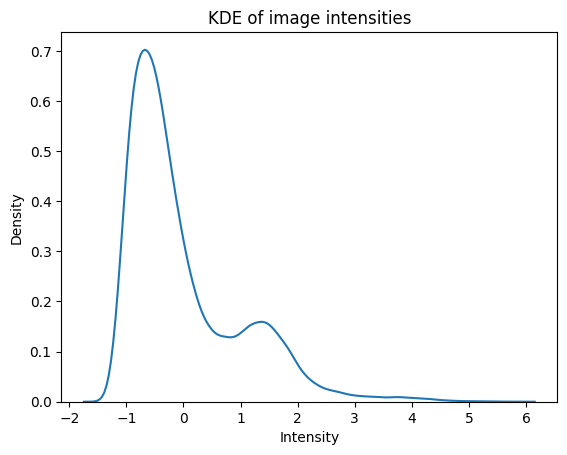

In [21]:
# plot kde of first image
# take smaller random sample
sample = np.random.choice(img.flatten(), 100000)
sns.kdeplot(sample)
plt.ylabel('Density')
plt.xlabel('Intensity')
plt.title('KDE of image intensities')
plt.show()

## Cycle Through Each Image, saving histogram (250 bins?) and getting average template

In [22]:
# first find the range of intensities for all images
min_intensity = np.inf
max_intensity = -np.inf

for i in range(len(images)):
    img = np.load(images[i])
    min_i = img.min()
    max_i = img.max()
    if min_i < min_intensity:
        min_intensity = min_i
    if max_i > max_intensity:
        max_intensity = max_i

print('Min intensity:', min_intensity)
print('Max intensity:', max_intensity)

Min intensity: -1.7830299
Max intensity: 10.026568


In [23]:
# choose range as -2 to 10
intensity_range = (-2, 10)

100%|███████████████████████████████████████████████████████████████████████████████| 148/148 [00:13<00:00, 11.02it/s]


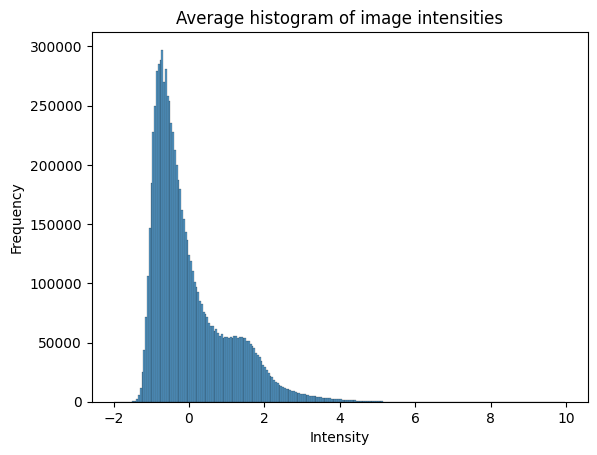

In [34]:
# Get average histogram of all images
# initialize average histogram
num_bins = 250
avg_hist = np.zeros(num_bins)
bin_edges = np.linspace(intensity_range[0], intensity_range[1], num_bins+1)

# loop through all images, using tqdm to keep track of progress
import tqdm
for i in tqdm.tqdm(range(len(images))):
    # load image
    img = np.load(images[i])
    # get histogram
    hist, _ = np.histogram(img.flatten(), bins=num_bins, range=intensity_range)
    # add to average histogram
    avg_hist += hist

# normalize average histogram
avg_hist = avg_hist / len(images)

# get bin centres for plotting
bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2

# plot average histogram, using sns and overlaying kde
sns.histplot(weights=avg_hist, bins=num_bins, x=bin_centres)
plt.ylabel('Frequency')
plt.xlabel('Intensity')
plt.title('Average histogram of image intensities')
plt.show()

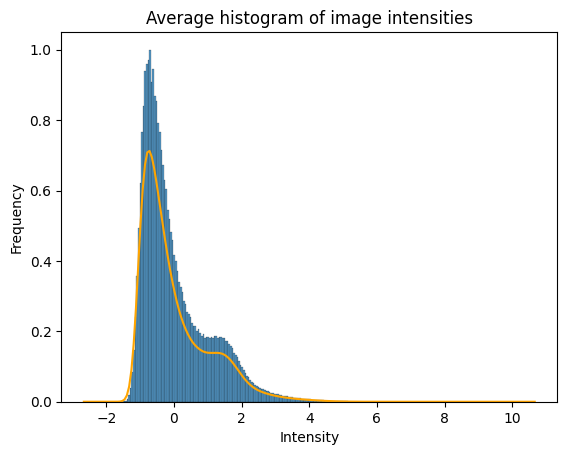

In [126]:
# plot hist of average histogram
sns.histplot(weights=(avg_hist/max(avg_hist)), bins=num_bins, x=bin_centres)
# plot kde of average histogram
sns.kdeplot(x=bin_centres, weights=avg_hist, bw_adjust=0.2, color='orange')

plt.ylabel('Frequency')
plt.xlabel('Intensity')
plt.title('Average histogram of image intensities')
plt.show()

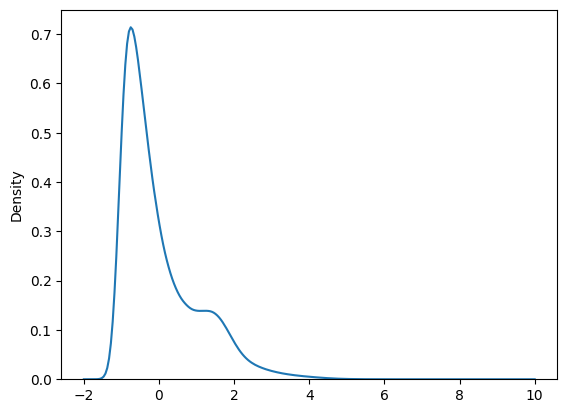

In [175]:
values = sns.kdeplot(x=bin_centres, weights=avg_hist, bw_adjust=0.2, gridsize=251, clip=intensity_range).get_lines()[0].get_data()

In [176]:
values[0].shape

(251,)

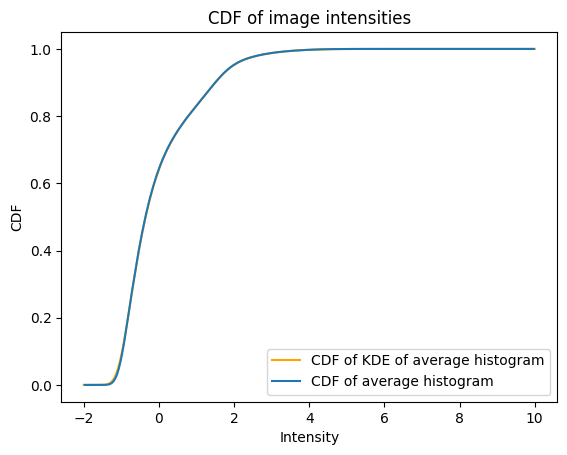

In [177]:
# cdf of kde of average histogram
cdf = np.cumsum(values[1]) / sum(values[1])
plt.plot(values[0], cdf, color='orange', label='CDF of KDE of average histogram')

# also plot the cdf of the average histogram
cdf_hist = np.cumsum(avg_hist) / sum(avg_hist)
plt.plot(bin_centres, cdf_hist, label='CDF of average histogram')

plt.ylabel('CDF')
plt.xlabel('Intensity')
plt.title('CDF of image intensities')
plt.legend()
plt.show()

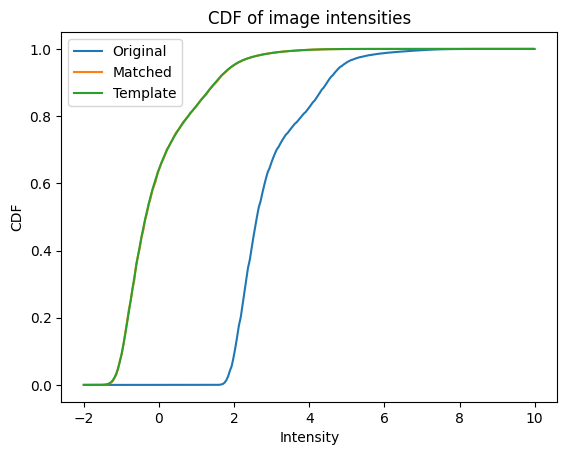

In [182]:
def match_histogram_3d(image, template_cdf, num_bins=250):
    """
    Match the histogram of a 3D image to a template histogram (with given number of bins).
    """
    # Flatten the 3D image into a 1D array
    img_flat = image.flatten()

    # Compute the histogram and CDF for the input image
    img_hist, img_bin_edges = np.histogram(img_flat, bins=num_bins, range=intensity_range)
    img_cdf = np.cumsum(img_hist) / img_hist.sum()

    # Create a mapping from the image CDF to the template CDF
    mapping = np.interp(img_cdf, template_cdf, img_bin_edges)

    # Apply the mapping to the flattened image
    img_matched_flat = np.interp(img_flat, img_bin_edges[:-1], mapping)

    # Reshape the matched image back to its original 3D shape
    img_matched = img_matched_flat.reshape(image.shape)
    
    return img_matched

num_bins=250
matched = match_histogram_3d(img, cdf)

# plot cdfs of original, matched and template
img_flat = img.flatten()
img_matched_flat = matched.flatten()

img_hist, img_bin_edges = np.histogram(img_flat, bins=num_bins, range=intensity_range)
img_cdf = np.cumsum(img_hist) / img_hist.sum()

matched_hist, matched_bin_edges = np.histogram(img_matched_flat, bins=num_bins, range=intensity_range)
matched_cdf = np.cumsum(matched_hist) / matched_hist.sum()

plt.plot(img_bin_edges[:-1], img_cdf, label='Original')
plt.plot(matched_bin_edges[:-1], matched_cdf, label='Matched')
plt.plot(values[0], cdf, label='Template')
plt.ylabel('CDF')
plt.xlabel('Intensity')
plt.title('CDF of image intensities')
plt.legend()
plt.show()

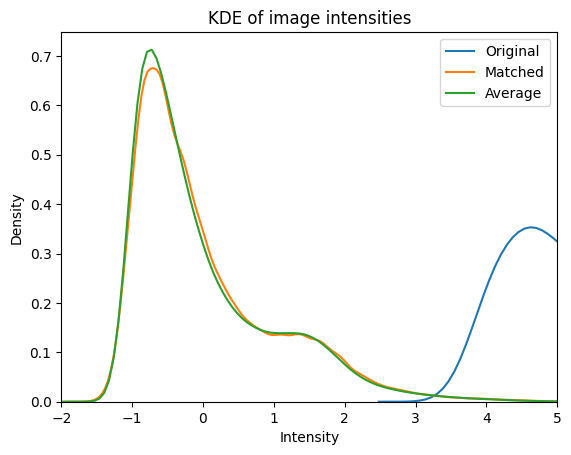

In [186]:
# plot kdes of original and matched images, as well as the histogram of the template image
# take smaller random sample
img*=2
sample = np.random.choice(img.flatten(), 100000)
sns.kdeplot(sample, label='Original')
sample_matched = np.random.choice(matched.flatten(), 100000)
sns.kdeplot(sample_matched, label='Matched')
sns.kdeplot(x=bin_centres, weights=avg_hist, bw_adjust=0.2, label='Average')
plt.ylabel('Density')
plt.xlim(-2, 5)
plt.xlabel('Intensity')
plt.title('KDE of image intensities')
plt.legend()
plt.show()

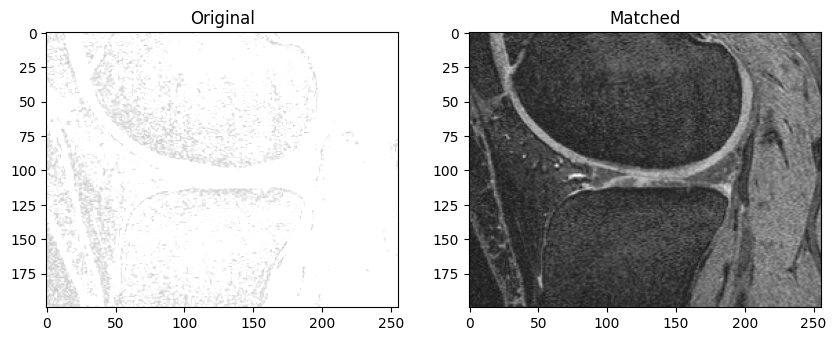

In [189]:
# plot slices of original and matched images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img[0,100,...], cmap='gray', vmin=-2, vmax=5)
plt.title('Original')
plt.subplot(1, 2, 2)
plt.imshow(matched[0,100,...], cmap='gray', vmin=-2, vmax=5)
plt.title('Matched')
plt.show()